It: 0, Loss: 2.619e+02, Y0: -0.267, Time: 29.27, Total Time: 29.27, Learning Rate: 1.000e-03
It: 100, Loss: 4.088e+01, Y0: 0.246, Time: 18.38, Total Time: 47.66, Learning Rate: 1.000e-03
It: 200, Loss: 4.028e+01, Y0: 0.079, Time: 20.45, Total Time: 68.11, Learning Rate: 1.000e-03
It: 300, Loss: 2.865e+01, Y0: 0.184, Time: 18.38, Total Time: 86.49, Learning Rate: 1.000e-03
It: 400, Loss: 3.387e+01, Y0: 0.284, Time: 18.81, Total Time: 105.30, Learning Rate: 1.000e-03
It: 500, Loss: 4.087e+01, Y0: 0.192, Time: 19.66, Total Time: 124.96, Learning Rate: 1.000e-03
It: 600, Loss: 3.910e+01, Y0: 0.388, Time: 18.42, Total Time: 143.38, Learning Rate: 1.000e-03
It: 700, Loss: 4.676e+01, Y0: 0.322, Time: 19.47, Total Time: 162.86, Learning Rate: 1.000e-03
It: 800, Loss: 5.069e+01, Y0: 0.578, Time: 18.75, Total Time: 181.61, Learning Rate: 1.000e-03
It: 900, Loss: 2.600e+01, Y0: 0.239, Time: 18.26, Total Time: 199.86, Learning Rate: 1.000e-03
It: 1000, Loss: 2.879e+01, Y0: 0.293, Time: 20.11, Tota

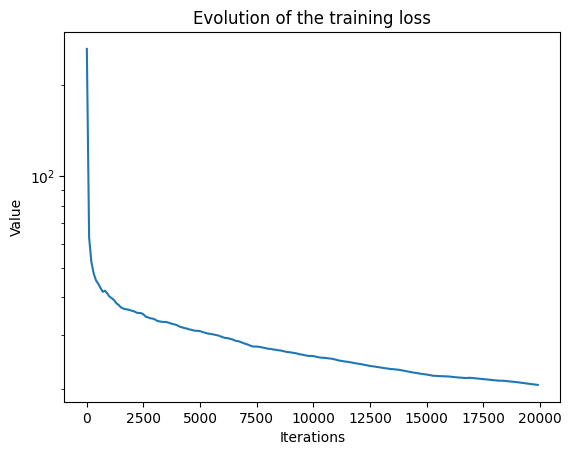

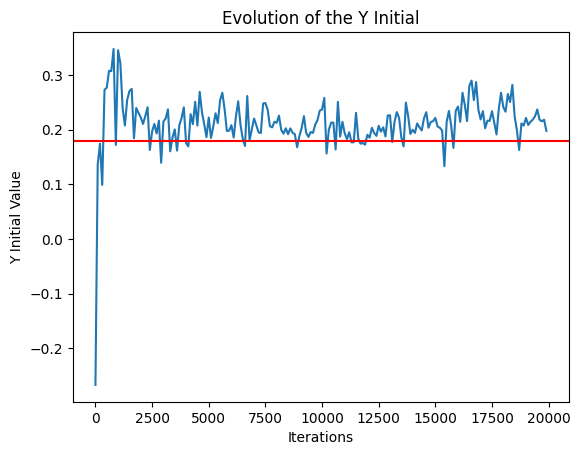

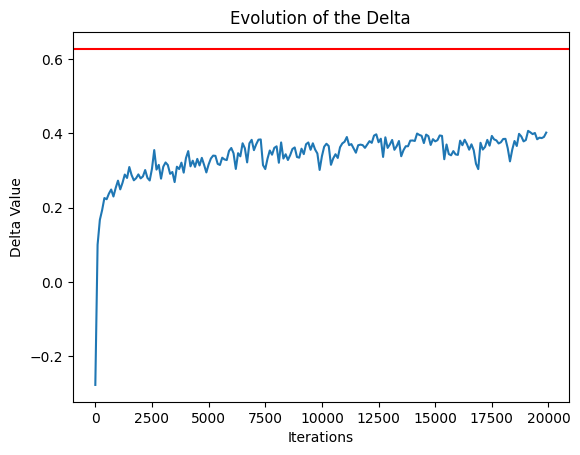

In [7]:

# basic imports
import os, random
import numpy as np
import datetime as dt
import time
from abc import ABC, abstractmethod
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt

from numpy import *
from scipy.stats import norm
# warnings
import warnings

warnings.filterwarnings('ignore')

# tensorflow
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

tf.keras.backend.clear_session()

from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout, Dense, Flatten, Layer, Add



class Linear(Layer):
    """Define Linear layers"""

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        self.in_dims = in_features
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'
        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    #@tf.function
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class StableLinear(Layer):
    """Define Stable Linear layers"""

    def __init__(self, in_features, out_features):
        super(StableLinear, self).__init__()

        self.epsilon = 0.01
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'

        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    def call(self, inputs):
        w = self.weight_constraint(self.w)
        return tf.matmul(inputs, w) + self.b

    def weight_constraint(self, weight):
        delta = 1 - 2 * self.epsilon
        RtR = tf.matmul(tf.transpose(weight), weight)
        norm = tf.norm(RtR)

        #if norm > delta: RtR = delta ** (1 / 2) * RtR / (norm ** (1 / 2))
        RtR_new = tf.sqrt(delta) * RtR / tf.sqrt(norm)
        RtR_update = tf.minimum(RtR_new, RtR)
        A = RtR_update + tf.eye(RtR.shape[0]) * self.epsilon
        return -A


class NaisNet(Model):
    """ Building NAIS_Net network using keras """

    def __init__(self, layers):
        super(NaisNet, self).__init__()

        self.layer1 = Linear(layers[0], layers[1])

        self.layer2 = StableLinear(layers[1], layers[2])
        self.layer2_input = Linear(layers[0], layers[2])

        self.layer3 = StableLinear(layers[2], layers[3])
        self.layer3_input = Linear(layers[0], layers[3])

        self.layer4 = StableLinear(layers[3], layers[4])
        self.layer4_input = Linear(layers[0], layers[4])

        self.layer5 = Linear(layers[4], layers[5])

    # Building block for the NAIS-Net
    def call(self, x):
        """Process stages in the block"""

        u = x

        output = self.layer1(u)  # layer 1
        output = tf.sin(output)

        X1 = output
        output = self.layer2(output)  # layer 2
        output = Add()([self.layer2_input(u), output])
        output = tf.sin(output)
        output = Add()([X1, output])

        X2 = output
        output = self.layer3(output)  # layer 3
        output = Add()([self.layer3_input(u), output])
        output = tf.sin(output)
        output = Add()([X2, output])

        X3 = output
        output = self.layer4(output)  # layer 4
        output = Add()([self.layer4_input(u), output])
        output = tf.sin(output)
        output = Add()([X3, output])

        output = self.layer5(output)  # layer 5

        return output

class FBSNN(ABC):
    """Forward-Backward SDEs using NAIS-Net """

    def __init__(self, Xi, T, M, N, D, layers):

        self.Xi = Xi  # initial point

        self.T = T  # terminal time
        self.M = M  # number of trajectories
        self.N = N  # number of time snapshots
        self.D = D  # number of dimensions

        # Initialize NN
        self.model = NaisNet(layers)

        # Record the loss
        self.training_loss = []
        self.iteration = []
        self.Y0_iter = []
        self.Z0_iter = []

    @tf.function
    def net_u(self, t, X):  # M x 1, M x D

        u = self.model(tf.concat([t, X], 1))  # M x 1
        Du = tf.gradients(u, X)[0]  # M x D

        return u, Du

    @tf.function
    def Dg_tf(self, X):  # M x D
        return tf.gradients(self.g_tf(X), X)[0]  # M x D

    def loss_function(self, t, W, Xi):

        loss = 0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:, 0, :]
        W0 = W[:, 0, :]

        X0 = tf.tile(Xi, [self.M, 1])  # M x D
        Y0, Z0 = self.net_u(t0, X0)  # M x 1, M x D

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        for n in range(0, self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]
            X1 = X0 + self.mu_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.squeeze(
                tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1)), axis=[-1])
            Y1_tilde = Y0 + self.phi_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.reduce_sum(
                Z0 * tf.squeeze(tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1))), axis=1,
                keepdims=True)
            Y1, Z1 = self.net_u(t1, X1)

            loss += tf.reduce_sum(tf.pow(Y1 - Y1_tilde, 2))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)

        loss += tf.reduce_sum(tf.pow(Y1 - self.g_tf(X1), 2))
        loss += tf.reduce_sum(tf.pow(Z1 - self.Dg_tf(X1), 2))

        X = tf.stack(X_list, axis=1)
        Y = tf.stack(Y_list, axis=1)
        Z = tf.stack(Z_list, axis=1)
        Y0 = tf.reduce_mean(Y, axis=0)

        return loss, X, Y, Y0[0, 0], Z

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M, N + 1, 1))  # M x (N+1) x 1
        DW = np.zeros((M, N + 1, D))  # M x (N+1) x D

        dt = T / N

        Dt[:, 1:, :] = dt
        DW[:, 1:, :] = np.sqrt(dt) * np.random.normal(size=(M, N, D))

        t = np.cumsum(Dt, axis=1)  # M x (N+1) x 1
        W = np.cumsum(DW, axis=1)  # M x (N+1) x D

        return t, W

    @tf.function
    def train_step(self, optimizers, t, winner, Xi):
        # Optimizers
        optimizer = optimizers

        with tf.GradientTape() as tape:
            loss_value, X_pred, Y_pred, Y0_pred, Z_pred = self.loss_function(t, winner, Xi)

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return loss_value, Y0_pred, Z_pred

    def train(self, N_Iter, learning_rate):

        loss_temp = np.array([])
        Y0_pred_temp = np.array([])
        Z0_pred_temp = np.array([])
        # Optimizers
        self.optimizer = Adam(learning_rate=learning_rate)

        start_time = time.time()
        ini_time = time.time()

        for it in range(N_Iter):


          t_batch, W_batch = self.fetch_minibatch()  # M x (N+1) x 1, M x (N+1) x D
          t_batch = tf.convert_to_tensor(t_batch, dtype=tf.float32)
          W_batch = tf.convert_to_tensor(W_batch, dtype=tf.float32)
          self.Xi = tf.convert_to_tensor(self.Xi, dtype=tf.float32)

          loss_value, Y0_pred, Z_pred = self.train_step(self.optimizer, t_batch, W_batch, self.Xi)

          if it % 100 == 0:
              elapsed = time.time() - start_time
              total_time = time.time() - ini_time
              print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Total Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_pred, elapsed, total_time, learning_rate))
              start_time = time.time()

          loss_temp = np.append(loss_temp, loss_value.numpy())
          Y0_pred_temp = np.append(Y0_pred_temp, Y0_pred.numpy())

          Z0 = tf.reduce_mean(Z_pred, axis=0)
          Z0_pred_temp = np.append(Z0_pred_temp, Z0.numpy()[-1, :])

          if it % 100 == 0:
            self.training_loss.append(loss_temp.mean())
            self.Y0_iter.append(Y0_pred_temp[-100:].mean())
            self.Z0_iter.append(Z0_pred_temp[-100:].mean())
            self.iteration.append(it)

          graph = np.stack((self.iteration, self.training_loss))
          Y0_iter = np.stack((self.iteration, self.Y0_iter))
          Z0_iter = np.stack((self.iteration, self.Z0_iter))

        return graph, Y0_iter, Z0_iter


    def predict(self, Xi_star, t_star, W_star):
        t_star = tf.convert_to_tensor(t_star, dtype=tf.float32)
        W_star = tf.convert_to_tensor(W_star, dtype=tf.float32)
        Xi_star = tf.convert_to_tensor(Xi_star, dtype=tf.float32)

        loss, X_star, Y_star, Y0_pred, Z_pred = self.loss_function(t_star, W_star, Xi_star)

        return X_star, Y_star, Z_pred

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        pass  # M x1

    @abstractmethod
    def g_tf(self, X):  # M x D
        pass  # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M, D])  # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y):  # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M, D]))  # M x D x D
    ###########################################################################


class BlackScholes(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers):
        super().__init__(Xi, T, M, N, D, layers)

    def phi_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        return 0.05*Y # M x 1

    def g_tf(self, X):  # M x D
        K = 1.0
        X0 = tf.tile(self.Xi, [self.M, 1])  # M x D
        X0 = tf.convert_to_tensor(X0, dtype=tf.float32)
        return tf.maximum(X-K*X0, 0) # M x 1

    def mu_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        return 0.05*X  # M x D

    def sigma_tf(self, t, X, Y):  # M x 1, M x D, M x 1
        return 0.4*tf.linalg.diag(X)# M x D x D

    ###########################################################################



if __name__ == "__main__":
    M = 100  # number of trajectories (batch size)
    N = 48  # number of time snapshots
    D = 1  # number of dimensions

    layers = [D+1] + 4 * [110] + [1]

    Xi = np.array([1.0])[None, :]
    T = 1.0


    model = BlackScholes(Xi, T, M, N, D, layers)

    graph, Y0_iter, Z0_iter = model.train(2*10**4, 1e-3)

    np.random.seed(42)
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)


    def u_exact(t, X):  # (N+1) x 1, (N+1) x D

        r = 0.05
        sigma_max = 0.4
        K = 1.0
        X0 = Xi
        E = K*X0
        a = sigma_max * (t**0.5)
        d1 = log(X/E) + (r + 0.5 * sigma_max**2) * t / a
        d2 = d1 - a
        payoff = X * norm.cdf(d1) - E * e**(-r * t) * norm.cdf(d2)
        delta = norm.cdf(d1)
        return payoff, delta

    Y0_test, delta = u_exact(T, Xi)

    plt.figure()
    plt.plot(graph[0], graph[1])
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    plt.yscale("log")
    plt.title('Evolution of the training loss')
    plt.savefig(str(D) + 'train-loss, ')

    plt.figure()
    plt.plot(Y0_iter[0], Y0_iter[1])
    plt.axhline(Y0_test, color='r')
    plt.xlabel('Iterations')
    plt.ylabel('Y Initial Value')
    #plt.yscale("log")
    plt.title('Evolution of the Y Initial')
    plt.savefig(str(D) + ' Initial')

    plt.figure()
    plt.plot(Z0_iter[0], Z0_iter[1])
    plt.axhline(delta, color='r')
    plt.xlabel('Iterations')
    plt.ylabel('Delta Value')
    #plt.yscale("log")
    plt.title('Evolution of the Delta')
    plt.savefig(str(D) + 'Delta')

In [8]:
  np.random.seed(42)
  t_test, W_test = model.fetch_minibatch()
  X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)

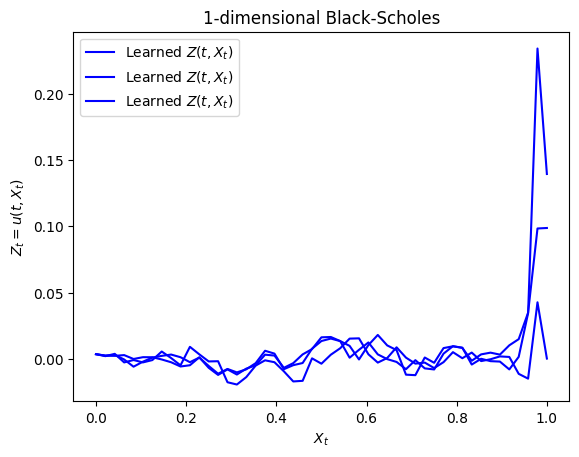

In [9]:
plt.figure()
plt.plot(t_test[0:3, :, 0].T, Z_pred[0:3, :, 0].T, 'b', label='Learned $Z(t,X_t)$')

plt.xlabel('$X_t$')
plt.ylabel('$Z_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes')
plt.legend()
plt.savefig(str(D) + '-dimensional Z-trace')

In [10]:
Y_pred = np.mean(Y_pred, axis=0, keepdims=True)

In [14]:
Y_pred[0, 0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.20757724], dtype=float32)>

In [15]:
Y0_test

array([[0.18022951]])

In [11]:
relative_error = Y_pred[0, 0] - Y0_test
print('Relative Error is: {}'.format(relative_error))

Relative Error is: [[0.02734773]]


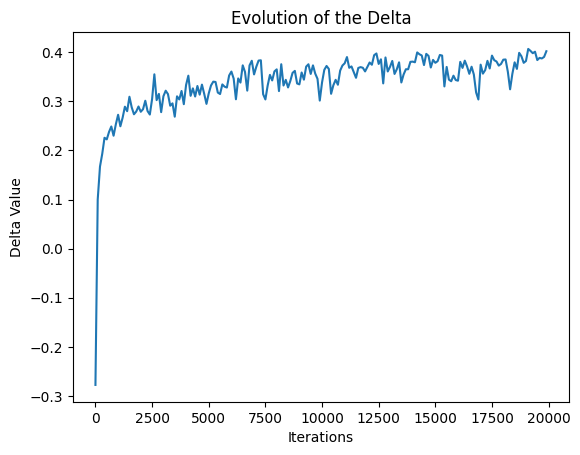

In [12]:
    plt.figure()
    plt.plot(Z0_iter[0], Z0_iter[1])
    #plt.axhline(delta, color='r')
    plt.xlabel('Iterations')
    plt.ylabel('Delta Value')
    #plt.yscale("log")
    plt.title('Evolution of the Delta')
    plt.savefig(str(D) + 'Delta_1')

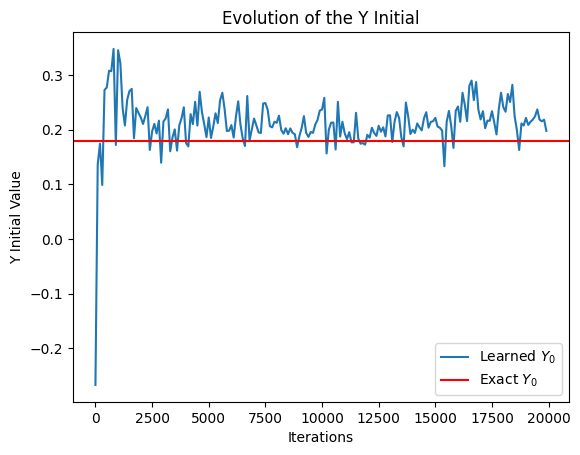

In [13]:
    plt.figure()
    plt.plot(Y0_iter[0], Y0_iter[1], label='Learned $Y_0$')
    plt.axhline(Y0_test, color='r', label='Exact $Y_0$')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Y Initial Value')
    #plt.yscale("log")
    plt.title('Evolution of the Y Initial')
    plt.savefig(str(D) + ' Initial')

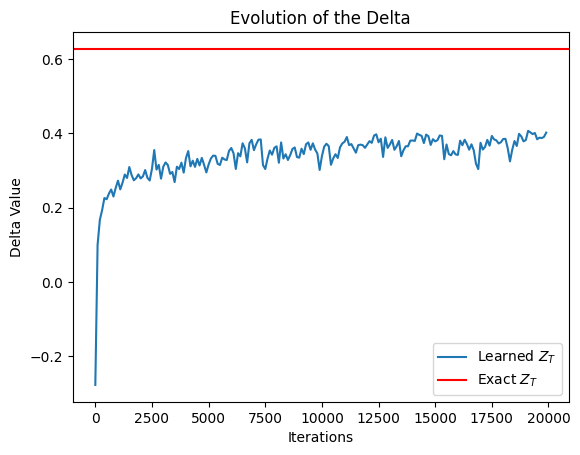

In [17]:
    plt.figure()
    plt.plot(Z0_iter[0], Z0_iter[1], label='Learned $Z_T$')
    plt.axhline(delta, color='r', label='Exact $Z_T$')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Delta Value')
    #plt.yscale("log")
    plt.title('Evolution of the Delta')
    plt.savefig(str(D) + 'Delta')

In [27]:
X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)

In [31]:
Y_pred_mean = np.mean(Y_pred, axis=0)
Y_pred_std = np.std(Y_pred, axis=0)

In [36]:
print('Y0_mean is: {}'.format(Y_pred_mean[0, 0]))
print('Y0_exact is: {}'.format(Y0_test))
print('Y0_std is: {}'.format(Y_pred_std[0, 0]))

Y0_mean is: 0.20757724344730377
Y0_exact is: [[0.18022951]]
Y0_std is: 5.960464477539063e-08


In [28]:
Z_pred_mean = np.mean(Z_pred, axis=0)

In [29]:
Z_pred_std = np.std(Z_pred, axis=0)

In [34]:
print('Delta_mean is: {}'.format(Z_pred_mean[-1, 0]))
print('Delta_std is: {}'.format(Z_pred_std[-1, 0]))

Delta_mean is: 0.4412361979484558
Delta_std is: 0.41632726788520813


In [35]:
delta_relative_error = np.abs(Z_pred_mean[-1, 0] - delta)
print('Relative Error is: {}'.format(delta_relative_error))

Relative Error is: [[0.18617327]]
